### ***Deep Learning for Channel Coding via Neural Mutual Information Estimation***

This code implements a **communication system using deep learning** techniques.

- The main idea is to use an autoencoder to enhance the encoding and decoding of information. The autoencoder efficiently encodes data, which is then transmitted through a noisy channel. Finally, the received data is decoded by another deep learning model.

- The process involves optimizing the models to minimize the bit error rate (BER) under varying signal-to-noise ratio (SNR) conditions. Additionally, neural networks are used to estimate mutual information to further improve the system's performance.

In [1]:
import sys
import itertools
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from scipy import special
from tensorflow import keras
import matplotlib.pyplot as plt
assert sys.version_info >= (3, 5)
from tensorflow.keras import layers

# --------------------------------------------------------------------- Definition Of Constants ---------------------------------------------------------------------
M = 16
k = int(np.log2(M))
n = 1
TRAINING_SNR = 7
BINARY_INP = True
rayleigh = False

### **The AutoEncoder class implements an end-to-end communication system using deep learning techniques.**

It consists of an encoder, a channel model, and a decoder. The encoder maps input messages to codewords, the channel model simulates the transmission with noise, and the decoder attempts to reconstruct the original messages from the noisy codewords.

This class supports both binary and non-binary inputs, and can operate with either an additive white `Gaussian noise (AWGN) channel` or a Rayleigh fading channel. Key functionalities include normalization of codewords, shaping the tensor to appropriate dimensions for transmission, and calculating the `bit error rate (BER)` for evaluating the performance.


- Methods:

   - __init__: Initializes the AutoEncoder with given parameters and constructs the encoder, channel, and decoder models.

   - EbNo_to_noise: Converts the given Eb/No value in dB to the standard deviation of the noise.

   - sample_Rayleigh_channel: Simulates the transmission over a Rayleigh fading channel with added noise.
   
   - random_sample: Generates random input messages for training or testing.

   - B_Ber_m: Computes the Batch Bit Error Rate (BER) between the input and decoded messages.

   - test_encoding: Tests the encoding process and visualizes the encoded messages in a 2D plot.


In [2]:
class AutoEncoder:
    def __init__(self, M, n, training_snr, rayleigh=False, binary_input=True):
        self.M = M
        self.k = int(np.log2(M))
        self.n = n
        self.training_snr = training_snr
        self.rayleigh = rayleigh
        self.binary_input = binary_input

        self.noise_std = self.EbNo_to_noise(training_snr)

        # Define custom layers
        self.norm_layer = layers.Lambda(lambda x: tf.divide(x, tf.sqrt(2 * tf.reduce_mean(tf.square(x)))))
        self.shape_layer = layers.Lambda(lambda x: tf.reshape(x, shape=[-1, 2, n]))
        self.shape_layer2 = layers.Lambda(lambda x: tf.reshape(x, shape=[-1, 2 * n]))
        self.channel_layer = layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=self.noise_std))

        # Define the encoder model
        if binary_input:
            self.encoder = keras.models.Sequential([
                keras.layers.InputLayer(input_shape=[k]),
                keras.layers.Dense(2 * k, activation="elu"),
                keras.layers.Dense(2 * n, activation=None),
                self.shape_layer,
                self.norm_layer
            ])
        else:
            self.encoder = keras.models.Sequential([
                keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal', input_length=1),
                keras.layers.Dense(M, activation="elu"),
                keras.layers.Dense(2 * n, activation=None),
                self.shape_layer,
                self.norm_layer
            ])

        # Define the channel model
        if rayleigh:
            self.channel = keras.models.Sequential([
                layers.Lambda(lambda x: self.sample_Rayleigh_channel(x, self.noise_std))
            ])
        else:
            self.channel = keras.models.Sequential([
                self.channel_layer
            ])

        self.decoder = keras.models.Sequential([
            keras.layers.InputLayer(input_shape=[2, n]),
            self.shape_layer2,
            keras.layers.Dense(2 * k, activation="elu"),
            keras.layers.Dense(k, activation='sigmoid') if binary_input else keras.layers.Dense(M, activation="softmax")
        ])
        self.autoencoder = keras.models.Sequential([self.encoder, self.channel, self.decoder])

    def EbNo_to_noise(self, ebnodb):
        '''Convert Eb/N0 (dB) to noise standard deviation.'''
        ebno = 10**(ebnodb / 10)                                                                                        # Convert dB to linear scale
        noise_std = 1 / np.sqrt(2 * (self.k / self.n) * ebno)                                                           # Compute noise std deviation
        return noise_std

    def sample_Rayleigh_channel(self, x, noise_std):
        '''Simulate a Rayleigh channel with noise.'''
        h_sample = (1 / np.sqrt(2)) * tf.sqrt(tf.random.normal(tf.shape(x))**2 + tf.random.normal(tf.shape(x))**2)      # Generate Rayleigh channel coefficients
        z_sample = tf.random.normal(tf.shape(x), stddev=noise_std)                                                      # Generate noise
        y_sample = x + tf.divide(z_sample, h_sample)                                                                    # Add noise to the signal
        return tf.cast(y_sample, tf.float32)                                                                            # Return noisy signal

    def random_sample(self, batch_size=32):
        '''Generate random binary or integer samples.'''
        if self.binary_input:
            msg = np.random.randint(2, size=(batch_size, self.k))                                                       # Binary input
        else:
            msg = np.random.randint(self.M, size=(batch_size, 1))                                                       # Integer input
        return msg

    def B_Ber_m(self, input_msg, msg):
        '''Compute the Batch Bit Error Rate (BBER).'''
        batch_size = input_msg.shape[0]
        if self.binary_input:
            pred_error = tf.not_equal(input_msg, tf.round(msg))                                                         # Compare predictions with actual
            pred_error_msg = tf.reduce_max(tf.cast(pred_error, tf.float32), axis=1)                                     # Max error per sample
            bber = tf.reduce_mean(pred_error_msg)                                                                       # Mean error over batch
        else:
            pred_error = tf.not_equal(tf.reshape(input_msg, shape=(-1, batch_size)), tf.argmax(msg, 1))                 # Compare class predictions
            bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))                                                      # Mean error over batch
        return bber

    def test_encoding(self):
        if self.binary_input:
            inp = np.array([list(i) for i in itertools.product([0, 1], repeat=k)])
        else:
            inp = np.arange(0, self.M)
        coding = self.encoder.predict(inp)
        fig = plt.figure(figsize=(4, 4))
        plt.plot(coding[:, 0], coding[:, 1], "b.")
        plt.xlabel("$x_1$", fontsize=18)
        plt.ylabel("$x_2$", fontsize=18, rotation=0)
        plt.grid(True)
        plt.gca().set_ylim(-2, 2)
        plt.gca().set_xlim(-2, 2)
        plt.show()


### **The NNFunction class defines a neural network-based function approximator using the TensorFlow Keras Model API.**

It builds a fully connected **neural network** with a specified number of hidden layers, hidden dimension, and activation function. The primary purpose of this class is to compute a score for each pair of inputs from two batches. Key functionalities include tiling the input tensors, concatenating them, and passing through the neural network to obtain a score for each pair.


- Methods:
   - __init__: Initializes the `NNFunction` with the specified hidden dimension, number of layers, and activation function.

   - call: Computes scores for each pair of inputs from two batches by tiling, concatenating, and passing through the neural network.


In [3]:
class NNFunction(tf.keras.Model):
    def __init__(self, hidden_dim, layers, activation, **extra_kwargs):
        super(NNFunction, self).__init__()
        self._f = tf.keras.Sequential(
            [tf.keras.layers.Dense(hidden_dim, activation) for _ in range(layers)] +
            [tf.keras.layers.Dense(1)]
        )

    def call(self, x, y):
        batch_size = tf.shape(x)[0]
        x_tiled = tf.tile(x[None, :], (batch_size, 1, 1))
        y_tiled = tf.tile(y[:, None], (1, batch_size, 1))
        xy_pairs = tf.reshape(tf.concat((x_tiled, y_tiled), axis=2), [batch_size * batch_size, -1])
        scores = self._f(xy_pairs)
        return tf.transpose(tf.reshape(scores, [batch_size, batch_size]))

### **The Trainer class is responsible for training and evaluating the AutoEncoder and NNFunction models.**

It handles three types of training: `Mutual Information (MI) estimation`, decoder training, and encoder training. It also provides methods for plotting loss and testing the autoencoder's performance over a range of `signal-to-noise ratios (SNRs)`.


- Methods:
   - __init__: Initializes the Trainer with the AutoEncoder and NNFunction instances, setting up loss functions and metrics.

   - MINE: Computes the Mutual Information Neural Estimator (MINE) score from the given pairwise scores.

   - plot_loss: Prints loss and Batch Bit Error Rate (BBER) at regular intervals and optionally plots encoding results.

   - plot_batch_loss: Prints interim results for the current epoch, including loss and BBER.

   - train_mi: Trains the Mutual Information estimator using gradient descent, optimizing the MI score.

   - train_decoder: Trains the autoencoder's decoder by minimizing the cross-entropy loss between input and predicted outputs.

   - train_encoder: Trains the autoencoder's encoder by optimizing the MI score and includes an additional training step for the MI estimator.

   - Test_AE: Evaluates the autoencoder's performance across a range of SNR values, computing the BBER for each SNR level.


In [2]:
class Trainer:
    def __init__(self, autoencoder, nn_function):
        self.autoencoder = autoencoder
        self.nn_function = nn_function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy() if autoencoder.binary_input else tf.keras.losses.SparseCategoricalCrossentropy()
        self.mean_loss = tf.keras.metrics.Mean()

    def MINE(self, scores):
        def marg(x):
            batch_size = x.shape[0]
            marg_ = tf.reduce_mean(tf.exp(x - tf.linalg.tensor_diag(np.inf * tf.ones(batch_size))))
            return marg_ * ((batch_size * batch_size) / (batch_size * (batch_size - 1.)))

        joint_term = tf.reduce_mean(tf.linalg.diag_part(scores))
        marg_term = marg(scores)
        return joint_term - tf.math.log(marg_term)

    def plot_loss(self, step, epoch, mean_loss, X_batch, y_pred, plot_encoding):
        template = 'Iteration: {}, Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
        if step % 10 == 0:
            print(template.format(step, epoch, mean_loss.result(), self.autoencoder.B_Ber_m(X_batch, y_pred)))
            if plot_encoding:
                self.autoencoder.test_encoding()

    def plot_batch_loss(self, epoch, mean_loss, X_batch, y_pred):
        template_outer_loop = 'Interim result for Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
        print(template_outer_loop.format(epoch, mean_loss.result(), self.autoencoder.B_Ber_m(X_batch, y_pred)))


# ----------------------------------------------------------------- TRAINING METHODS -------------------------------------------------------------------------------

    def train_mi(self, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.005):
        optimizer_mi = tf.keras.optimizers.Nadam(learning_rate=learning_rate)                                                                     # Initialize optimizer for mutual information estimation with specified learning rate
        for epoch in range(1, n_epochs + 1):
            print("Training in Epoch {}/{}".format(epoch, n_epochs))
            for step in range(1, n_steps + 1):
                X_batch = self.autoencoder.random_sample(batch_size)                                                                              # Generate a batch of random samples
                with tf.GradientTape() as tape:                                                                                                   # Compute gradients using a gradient tape
                    x_enc = self.autoencoder.encoder(X_batch, training=True)                                                                      # Encode the batch of samples
                    y_recv = self.autoencoder.channel(x_enc)                                                                                      # Pass the encoded samples through the channel
                    x = tf.reshape(x_enc, shape=[batch_size, 2 * self.autoencoder.n])                                                             # Reshape tensors for mutual information estimation
                    y = tf.reshape(y_recv, shape=[batch_size, 2 * self.autoencoder.n])
                    score = self.nn_function(x, y)                                                                                                # Compute mutual information score
                    loss = -self.MINE(score)                                                                                                      # Compute loss as negative MINE score
                    gradients = tape.gradient(loss, self.nn_function.trainable_variables)                                                         # Compute gradients with respect to NNFunction variables
                    optimizer_mi.apply_gradients(zip(gradients, self.nn_function.trainable_variables))                                            # Apply gradients to update NNFunction weights
                mi_avg = -self.mean_loss(loss)                                                                                                    # Average mutual information loss over the steps
            print('Epoch: {}, Mi is {}'.format(epoch, mi_avg))
            self.mean_loss.reset_state()                                                                                                          # Reset the mean loss metric for the next epoch

    def train_decoder(self, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.005, plot_encoding=True):
        optimizer_ae = tf.keras.optimizers.Nadam(learning_rate=learning_rate)                                                                     # Initialize optimizer for the autoencoder decoder with specified learning rate
        for epoch in range(1, n_epochs + 1):
            print("Training Bob in Epoch {}/{}".format(epoch, n_epochs))
            for step in range(1, n_steps + 1):
                X_batch = self.autoencoder.random_sample(batch_size)                                                                              # Generate a batch of random samples
                with tf.GradientTape() as tape:                                                                                                   # Compute gradients using a gradient tape
                    y_pred = self.autoencoder.autoencoder(X_batch, training=True)                                                                 # Pass the batch through the autoencoder
                    loss = tf.reduce_mean(self.loss_fn(X_batch, y_pred))                                                                          # Compute loss using the loss function
                    gradients = tape.gradient(loss, self.autoencoder.decoder.trainable_variables)                                                 # Compute gradients with respect to decoder variables
                    optimizer_ae.apply_gradients(zip(gradients, self.autoencoder.decoder.trainable_variables))                                    # Apply gradients to update decoder weights
                self.mean_loss(loss)                                                                                                              # Update the mean loss metric
                self.plot_loss(step, epoch, self.mean_loss, X_batch, y_pred, plot_encoding)                                                       # Plot the current loss and encoding performance if required
            self.plot_batch_loss(epoch, self.mean_loss, X_batch, y_pred)                                                                          # Plot the batch loss for the current epoch
            self.mean_loss.reset_state()                                                                                                          # Reset the mean loss metric for the next epoch

    def train_encoder(self, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.005):
        optimizer_ae = tf.keras.optimizers.Nadam(learning_rate=learning_rate)                                                                     # Initialize optimizer for the autoencoder encoder with specified learning rate
        optimizer_mi = tf.keras.optimizers.Nadam(learning_rate=0.005)                                                                             # Initialize optimizer for the mutual information estimator with a fixed learning rate
        for epoch in range(1, n_epochs + 1):
            print("Training Bob in Epoch {}/{}".format(epoch, n_epochs))
            for step in range(1, n_steps + 1):
                X_batch = self.autoencoder.random_sample(batch_size)                                                                              # Generate a batch of random samples
                with tf.GradientTape() as tape:                                                                                                   # Compute gradients using a gradient tape
                    x_enc = self.autoencoder.encoder(X_batch, training=True)                                                                      # Encode the batch of samples
                    y_recv = tf.identity(self.autoencoder.channel(x_enc))                                                                         # Pass the encoded samples through the channel
                    x = tf.reshape(x_enc, shape=[batch_size, 2 * self.autoencoder.n])                                                             # Reshape the tensors for MI estimation
                    y = tf.reshape(y_recv, shape=[batch_size, 2 * self.autoencoder.n])
                    score = self.nn_function(x, y)                                                                                                # Compute mutual information score
                    loss = -self.MINE(score)                                                                                                      # Compute loss as negative MINE score
                    gradients = tape.gradient(loss, self.autoencoder.encoder.trainable_variables)                                                 # Compute gradients with respect to encoder variables
                    optimizer_ae.apply_gradients(zip(gradients, self.autoencoder.encoder.trainable_variables))                                    # Apply gradients to update encoder weights
                mi_avg = -self.mean_loss(loss)                                                                                                    # Average mutual information loss over the steps
            with tf.GradientTape() as tape:                                                                                                       # Compute and update mutual information estimator
                X_batch = self.autoencoder.random_sample(batch_size)                                                                              # Sample batch data
                x_enc = self.autoencoder.encoder(X_batch, training=True)                                                                          # Encode batch data
                y_recv = self.autoencoder.channel(x_enc)                                                                                          # Pass encoded data through channel
                x = tf.reshape(x_enc, shape=[batch_size, 2 * self.autoencoder.n])                                                                 # Reshape encoded data
                y = tf.reshape(y_recv, shape=[batch_size, 2 * self.autoencoder.n])                                                                # Reshape received data
                score = self.nn_function(x, y)                                                                                                    # Compute mutual information score
                loss = -self.MINE(score)                                                                                                          # Calculate loss as negative MINE score
                gradients = tape.gradient(loss, self.nn_function.trainable_variables)                                                             # Compute gradients
                optimizer_mi.apply_gradients(zip(gradients, self.nn_function.trainable_variables))                                                # Update weights

    def Test_AE(self):
        '''Calculate Bit Error for varying SNRs'''
        snr_range = np.linspace(0, 15, 31)                                                                                                        # Define the range of SNR values to test
        bber_vec = [None] * len(snr_range)                                                                                                        # Initialize a list to store Bit Error Rate (BBER) for each SNR
        for db in range(len(snr_range)):
            for it in range(1, 1000):
                noise_std = self.autoencoder.EbNo_to_noise(snr_range[db])                                                                         # Convert SNR value to noise standard deviation
                X_batch = self.autoencoder.random_sample(500)                                                                                     # Generate a batch of random samples
                code_word = self.autoencoder.encoder(X_batch)                                                                                     # Encode the samples
                if self.autoencoder.rayleigh:                                                                                                     # Simulate channel reception based on Rayleigh fading or AWGN
                    rcvd_word = self.autoencoder.sample_Rayleigh_channel(code_word, noise_std)
                else:
                    rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
                dcoded_msg = self.autoencoder.decoder(rcvd_word)                                                                                  # Decode the received samples
                bber = self.autoencoder.B_Ber_m(X_batch, dcoded_msg)                                                                              # Compute Bit Error Rate (BBER)
                bber_avg = self.mean_loss(bber)                                                                                                   # Average BBER over trials
            bber_vec[db] = bber_avg                                                                                                               # Store the average BBER for the current SNR
            self.mean_loss.reset_state()                                                                                                          # Reset the mean loss metric
            if (db % 6 == 0) & (db > 0):                                                                                                          # Print progress every 6 SNR steps
                print(f'Progress: {db} of {30} parts')
        return (snr_range, bber_vec)


- This code demonstrates the training pipeline for an AutoEncoder model with `Mutual Information Neural Estimator (MINE)` and neural network-based components.

- It sets up the NNFunction for MI estimation and the AutoEncoder for encoding and decoding. The training involves `optimizing MI`, followed by successive refinement of the encoder and decoder.

- The process includes `training` epochs, testing encoding performance, and adjusting learning rates to improve the model's effectiveness and accuracy.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Training in Epoch 1/1
Epoch: 1, Mi is 1.4822927713394165
Training Bob in Epoch 1/5
Training Bob in Epoch 2/5
Training Bob in Epoch 3/5
Training Bob in Epoch 4/5
Training Bob in Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


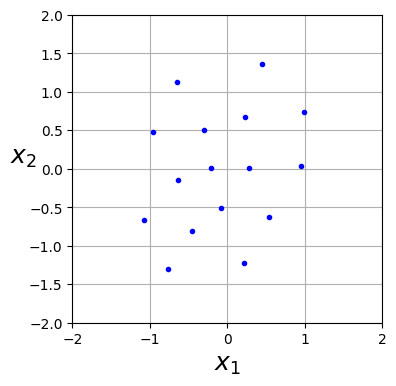

Training Bob in Epoch 1/5
Training Bob in Epoch 2/5
Training Bob in Epoch 3/5
Training Bob in Epoch 4/5
Training Bob in Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


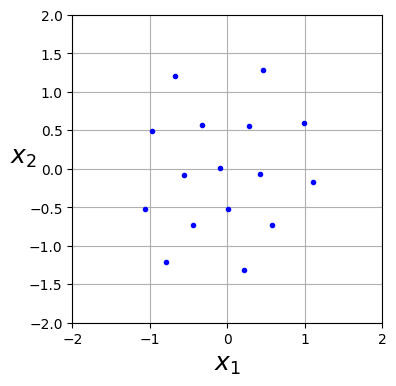

Training Bob in Epoch 1/5
Iteration: 10, Epoch: 1, Loss: -2.37077, Batch_BER: 0.76200
Iteration: 20, Epoch: 1, Loss: -2.36353, Batch_BER: 0.68000
Iteration: 30, Epoch: 1, Loss: -2.35650, Batch_BER: 0.61200
Iteration: 40, Epoch: 1, Loss: -2.34960, Batch_BER: 0.66800
Iteration: 50, Epoch: 1, Loss: -2.34278, Batch_BER: 0.64200
Iteration: 60, Epoch: 1, Loss: -2.33605, Batch_BER: 0.62400
Iteration: 70, Epoch: 1, Loss: -2.32937, Batch_BER: 0.61600
Iteration: 80, Epoch: 1, Loss: -2.32272, Batch_BER: 0.69200
Iteration: 90, Epoch: 1, Loss: -2.31614, Batch_BER: 0.64400
Iteration: 100, Epoch: 1, Loss: -2.30960, Batch_BER: 0.57800
Iteration: 110, Epoch: 1, Loss: -2.30310, Batch_BER: 0.58600
Iteration: 120, Epoch: 1, Loss: -2.29661, Batch_BER: 0.63200
Iteration: 130, Epoch: 1, Loss: -2.29018, Batch_BER: 0.58400
Iteration: 140, Epoch: 1, Loss: -2.28378, Batch_BER: 0.59200
Iteration: 150, Epoch: 1, Loss: -2.27742, Batch_BER: 0.61800
Iteration: 160, Epoch: 1, Loss: -2.27108, Batch_BER: 0.60000
Iterati

In [5]:
score_fn = NNFunction(hidden_dim=256, layers=2, activation='relu')                                                      # Initialize the NNFunction and AutoEncoder
autoencoder = AutoEncoder(M=M, n=n, training_snr=TRAINING_SNR, rayleigh=rayleigh, binary_input=BINARY_INP)
trainer = Trainer(autoencoder, score_fn)
trainer.train_mi(n_epochs=1, n_steps=500, batch_size=64)                                                                # Train Mutual Information Estimator
trainer.train_encoder(n_epochs=5, n_steps=400, batch_size=64, learning_rate=0.005)                                      # Train Encoder
autoencoder.test_encoding()                                                                                             # Test Encoding
trainer.train_encoder(n_epochs=5, n_steps=400, batch_size=64, learning_rate=0.001)                                      # Continue Training Encoder
autoencoder.test_encoding()                                                                                             # Test Encoding
trainer.train_decoder(n_epochs=5, n_steps=400, batch_size=500, learning_rate=0.015, plot_encoding=False)                # Train Decoder
trainer.train_decoder(n_epochs=4, n_steps=400, batch_size=500, learning_rate=0.01, plot_encoding=False)                 # Continue Training Decoder
trainer.train_decoder(n_epochs=1, n_steps=500, batch_size=500, learning_rate=0.005, plot_encoding=False)                # Final Training of Decoder